# Final Project


# Problem description

Time to show off everything you learned !

You will be performing a Classification task to analyze the sentiment of product reviews.

This is similar to a prior assignment
- With a different dataset
- Multinomial classification with 5 classes

But, by now, you have many more tools at your disposal.



## Grading

Prior assignments evaluated you step by step.

This project is results-based.

Your goal is to create a model
- That achieves an out of sample accuracy of at least 50%
- 60% would be better !



## Some possible approaches
- A review is a sequence of words.  You will need to deal with sequences in some manner.  Some suggestions
  - Pooling
  - Recurrent Neural Network
- Is there an advantage to recognizing *adjacent* words groups ("n-grams") rather than treating the document as an unordered set of words ?
  - Consider
    - "Machine Learning is easy not hard"
    - "Machine Learning is hard not easy"

  - Two sentences with identical words but different meaning.
  - Hint: Convolutional layer
- How should we encode words ?
  - OHE ? Embedding ?

We will **not specify** an approach.  Feel free to experiment.

Your goal is to produce a model with an out of sample accuracy meeting a minimum



## Learning objectives
- Experimentation !
- Error Analysis leading to model improvement
- Appreciate how choices impact number of weights

-

In [1]:
import tensorflow as tf

print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.3.0
Version 2, minor 3


In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [4]:
if IN_COLAB:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)
  import os
  drive_root = os.path.join(mount, "My Drive/Colab Notebooks/NYU/demo/edX")
     
  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)
   
  # Change to the directory
  proj_name = "sentiment_from_tweets"
  proj_root = os.path.join(drive_root, proj_name)
  print("\nColab: Changing directory to ", proj_root)
 
else:
    print("Running locally")
    proj_root="."
    # raise RuntimeError("This notebook should be run from Colab, not on the local machine")

%cd $proj_root 
%pwd

Colab: mounting Google drive on  /content/gdrive
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).

Colab: making sure  /content/gdrive/My Drive/Colab Notebooks/NYU/demo/edX  exists.

Colab: Changing directory to  /content/gdrive/My Drive/Colab Notebooks/NYU/demo/edX/sentiment_from_tweets
/content/gdrive/My Drive/Colab Notebooks/NYU/demo/edX/sentiment_from_tweets


'/content/gdrive/My Drive/Colab Notebooks/NYU/demo/edX/sentiment_from_tweets'

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn import preprocessing

import os
import math

%matplotlib inline

In [6]:
import tensorflow as tf
import pandas as pd

import re

In [7]:
from __future__ import print_function

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, LSTM

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras.utils import plot_model
import IPython

# API for students

We will define some utility routines.

This will simplify problem solving

More importantly: it adds structure to your submission so that it may be easily graded

- getData: Get a collection of labelled images, used as follows

  >`data, labels = getData()`
- showData: Visualize labelled images, used as follows

  >`showData(data, labels)`

- train: train a model and visualize its progress, used as follows

  >`train(model, X_train, y_train, model_name, epochs=max_epochs)`


In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

import os, gzip, json

DATA_DIR = "./data"

# File-specific info
data_file = "Software_5.json.gz"
textAttr, sentAttr, titleAttr = "reviewText", "overall", "title"



"""
 Parameters:
- vocab_size : number of words in the vocabulary 
- words_in_doc: number of words in a review

"""

#
# set parameters:
vocab_size_sm, words_in_doc_sm = 400, 100


special = { "<PAD>": 0, 
           }

def getDataRaw(dropAttrs=["summary"]):
  data = []
  
  with gzip.open( os.path.join(DATA_DIR, data_file) ) as f:
      for l in f:
          data.append(json.loads(l.strip()))
    
  df = pd.DataFrame.from_dict(data)

  # Drop attributes that may unfairly improve the model
  df.drop(columns=dropAttrs, inplace=True)
  return df

def getData(maxlen=1000, sample_size=4000):
  data_raw = getDataRaw()

  # Drop text that is too long
  data = data_raw[ data_raw.reviewText.str.len() < maxlen ]

  # Make the dataset smaller
  sample_size=4000
  data = data.sample(n=sample_size, random_state=42)

  return data


def getTextClean(data_raw):
    # Filter out rows with missing reveiws
    mask = data_raw[textAttr].isnull() 
    data_raw = data_raw[ ~mask ]
    docs = data_raw[textAttr].values
    
    # We will treat the sentiment values as Categorical, rather than numeric
    le = sklearn.preprocessing.LabelEncoder(  )
    sents = le.fit_transform( data_raw[ sentAttr] )
    
    return docs, sents

def encodeDocs(docs, vocab_size=vocab_size_sm, words_in_doc=words_in_doc_sm):
  tok = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
  tok.fit_on_texts(docs)

  encoded_docs = tok.texts_to_sequences(docs)
  encoded_docs_padded = sequence.pad_sequences(encoded_docs, maxlen=words_in_doc, padding='pre')

  return tok, encoded_docs, encoded_docs_padded


def showEncodedDocs(tok, encoded_docs_padded):
    word_index = tok.word_index
    
    # Add the special characters to the word to index map
    for word, idx in special.items():
      word_index[word] = idx

    # Reverse map: index to word
    # Index_word: map index to word
    index_word = { idx:w for (w, idx) in word_index.items() }

    for i, rev in enumerate(encoded_docs_padded[0:5]):
      # Map each index in the example back to word
      rev_words = [ index_word[idx] for idx in rev if idx != 0]
      print("{i:d}:\t{r:s}".format(i=i,  r= " ".join(rev_words)) )
      # sent = y_train[i]
      # print("{i:d}:\t({sent:s})\t{r:s}".format(i=i, sent=sentiment[y_train[i]], r= " ".join(rev_words)) )

def createOHE(vocab_size):
  mat = np.diag( np.ones(vocab_size))
  return mat

def getExamplesOHE(encoded_docs_padded, sents, vocab_size=vocab_size_sm):
    OHE = createOHE(vocab_size)
    X = np.zeros( (encoded_docs_padded.shape[0], encoded_docs_padded.shape[1], vocab_size) )

    # Convert each word to a OHE representation
    for doc_num in range(0, encoded_docs_padded.shape[0]):
        encoded_doc = encoded_docs_padded[doc_num]
        ohe_encoded_doc = OHE[ encoded_doc ]

        X[doc_num] = ohe_encoded_doc

    y = sents
    
    return X, y

   

'\n Parameters:\n- vocab_size : number of words in the vocabulary \n- words_in_doc: number of words in a review\n\n'

# Utility functions

In [9]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model

def plotModel(model, modelName):
  plotFile = modelName + ".png"
  plot_model(model, plotFile, show_shapes=True)

  return plotFile

def plot_training(history, metric="acc"):
  """
  Plot training and validation statistics
  - accuracy vs epoch number
  - loss     vs epoch number
  
  From https://www.learnopencv.com/keras-tutorial-fine-tuning-using-pre-trained-models/
  """  
  
  # Accuracy
  acc = history.history[metric]
  val_acc = history.history['val_' + metric]
  
  # Loss
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', label='Training ' + metric)
  plt.plot(epochs, val_acc, 'r', label='Validation ' + metric)
  plt.title('Training and validation ' + metric)
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [10]:
patience = 5
min_delta = .005
max_epochs=30

def trainModel(model, X, y, num_epochs=max_epochs, metric="mse"):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)
    model.compile(loss='mse',
                metrics=[metric]
                )
    
    es_callback = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

    callbacks = [ #es_callback,
            # ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
            ] 
    
    history = model.fit(X_train, y_train,
        epochs=num_epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks)

    return history

def trainModelCat(model, X, y, num_epochs=max_epochs, metric="acc"):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)
    model.compile(loss='sparse_categorical_crossentropy',
                metrics=[metric]
                )
    es_callback = EarlyStopping(monitor='val_loss', min_delta=min_delta, patience=patience, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    

    callbacks = [ es_callback,
            # ModelCheckpoint(filepath=modelName + ".ckpt", monitor='acc', save_best_only=True)
            ] 
   
    history = model.fit(X_train, y_train,
        epochs=num_epochs,
        validation_data=(X_val, y_val),
        callbacks=callbacks)

    return history

def eval_model(model, X, y):
  metrics = model.evaluate(x=X, y=y)

  result = {}
  for i, metric in enumerate(model.metrics_names):
    result[metric] = metrics[i]
    print( "{name:s}:{val:3.2f}".format(name=metric, val=float(metrics[i])) )

  return result




## Get the reviews (as text)
- ***Teacher version:** include code to read and format the raw data, producing a file for the students.  Hide this from student

- **Student version:** read file prepared by teacher version


In [11]:
data_raw = getData()


In [12]:
data_raw.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,unixReviewTime,vote,image
5000,5.0,True,"12 29, 2010",A33XMCG1UFDSY2,B003YJ5DKG,{'Platform:': ' PC Disc'},Nat Fruci,Quicken is an excellent financial tracking pro...,1293580800,NaN,NaN
7824,5.0,True,"05 4, 2014",A327HI0M9QL7JR,B00E6ONJJU,{'Platform:': ' PC Disc'},Robert A. Hansen,I prefer Kaspersky over any of the free anti-v...,1399161600,NaN,NaN
12119,5.0,True,"05 10, 2013",A2CJ4DLE8TWAGL,B01F7RJHIQ,{'Format:': ' DVD-ROM'},Mitchell,"Works with Windows 7 and 8 and XP, and for 3 P...",1368144000,NaN,NaN
11308,1.0,True,"05 17, 2018",A3NRQZDIN9CIZ0,B0148BYIAO,{'Platform:': ' PC Download'},Michael Perine,Received the card key. Very difficult to load...,1526515200,NaN,NaN
1401,2.0,True,"04 25, 2008",A1EH2S92FHWZRP,B000HCVR3K,NaN,Just a guy,I am a fairly well educated person who is hand...,1209081600,5,NaN


In [13]:
data_raw.shape



(4000, 11)

## Data preprocessing

The reviews are in the "reviewText" attribute.



You may try to use other attributes as additional features if you choose, but we suggest that your first model may use this as the only source of features.


# Get the labelled training data
- Features: docs.  Each document is a single review (sequence of characters)
- Targets/Labels: sents. Each is the sentiment associated with the review.

In [14]:
docs, sents = getTextClean(data_raw)

print("Docs shape is ", docs.shape)
print("Sents shape is ", sents.shape)

docs[:5]
print("\nPossible sentiment values: ",  np.unique(sents) ) 


Docs shape is  (4000,)
Sents shape is  (4000,)


array(['Quicken is an excellent financial tracking program.  It helps in the documentation of all expenses and income.  This allows one to monitor spending.',
       'I prefer Kaspersky over any of the free anti-virus programs out there.  Kaspersky is simple to use.  It is fast and works well.',
       'Works with Windows 7 and 8 and XP, and for 3 PC, will be the last time we see this and the only reason we bought it now, just to have Word and Excel before it became a 1 PC or yearly subscription.',
       'Received the card key.  Very difficult to load.  Microsoft kept saying that the product key is not in the database.  When I finally got MS to accept the product key, I got a statement that the product has expired on April 7, 2018, before the card key was even shipped.  This product is not even described as an annual subscription, but as a one-time purchase.  This is the second problem in a row that I have had with Amazon.  19% of the reviews for this product were one star.  Amazon, f


Possible sentiment values:  [0 1 2 3 4]


## More data preprocessing

We will need to convert the text in a *sequence* of numbers
- Break text up into words
- Assign each word a distinct integer

Moreover, it will be easier if all sequences have the same length.
We can add a "padding" character to the front if necessary.

We do this for you below.

Our method returns
- encoded_docs_padded: A matrix of training example *features*
  - Each row is an example
  - Each row is a *sequence* of fixed length
  - Each element of the sequence is an integer, encoding a word in the vocabulary
  - The sequence length of every example is *identical* because we have prepended padding if necessary
- encoded_docs: A matrix of *unpadded* training example *features*
- tok: the Tokenizer used to
  - parse strings of characters into words
  - encoded each word as an integer


You may study our methods parameters and modify them if you wish, e.g., alter the size of the vocabulary or length of sequences.

We suggest that your first model uses
- encoded_docs_padded as your set of training features, e.g., X
- sents: as your targets
with the default settings of the method.



In [15]:


tok, encoded_docs, encoded_docs_padded = encodeDocs(docs, vocab_size=vocab_size_sm, words_in_doc=words_in_doc_sm)

print("Training example features shape: ",encoded_docs_padded.shape)

print("Training example features: preview")
encoded_docs_padded[:3]



Training example features shape:  (4000, 100)
Training example features: preview


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 125,
          8,  39, 287,   1,   1,  31,   7,   1,  17,   2,   1,  11,  30,
          1,   5,   1,   9,   1,  45,   3,   1,   1],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   4,   

## Verify that our encoded documents are the same as the cleaned original

At this point: convince yourself that all we have done was encode words as integers and pad out all text to the same length.  The following will demonstrate this

In [16]:
showEncodedDocs(tok, encoded_docs_padded)

0:	quicken is an excellent <OOV> <OOV> program it <OOV> in the <OOV> of all <OOV> and <OOV> this <OOV> one to <OOV> <OOV>
1:	i <OOV> kaspersky over any of the free anti virus programs out there kaspersky is simple to use it is fast and works well
2:	works with windows 7 and 8 and xp and for 3 pc will be the last time we see this and the only <OOV> we bought it now just to have word and <OOV> before it <OOV> a 1 pc or <OOV> <OOV>
3:	<OOV> the card key very <OOV> to <OOV> microsoft <OOV> <OOV> that the product key is not in the <OOV> when i <OOV> got ms to <OOV> the product key i got a <OOV> that the product has <OOV> on <OOV> 7 <OOV> before the card key was even <OOV> this product is not even <OOV> as an <OOV> <OOV> but as a one time purchase this is the <OOV> problem in a <OOV> that i have had with amazon <OOV> of the reviews for this product were one <OOV> amazon <OOV> this problem
4:	i am a <OOV> well <OOV> <OOV> who is <OOV> around the <OOV> it took a <OOV> <OOV> <OOV> with microsof

# Split the examples into training and test (out of sample) data
- The number of test examples should be 10% of the total


In [17]:
# Set the following variables
# - X_train: ndarray of training example features
# - X_test:  ndarray of test example features
# - y_train: ndarray of training example targets
# - y_test:  ndarray of test example targets

### BEGIN SOLUTION
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(encoded_docs_padded, sents, test_size=0.10, random_state=42)

# OHE the X for some models
X_train_OHE, _ = getExamplesOHE(X_train, sents)
X_test_OHE, _ = getExamplesOHE(X_test, sents)
### END SOLUTION

In [18]:
# Set two variables
# example_sequence_len: length of the sequence
# example_num_features: number of features in a single element of the sequence (of a single example)

### BEGIN SOLUTION

# If using OHE:
example_shape = X_train_OHE.shape[1:]
example_sequence_len, example_num_features = example_shape[0], example_shape[1]

assert example_sequence_len == words_in_doc_sm
assert example_num_features == vocab_size_sm

# If NOT using OHE
example_shape = X_train.shape[1:]
example_sequence_len, example_num_features = example_shape[0], tok.num_words

assert example_sequence_len == words_in_doc_sm
assert example_num_features == vocab_size_sm

### END SOLUTION

# Create your model



In [19]:
### BEGIN SOLUTION
# Set variables
# - model: a Keras Sequential model to predict sentiment

### END SOLUTION

# Sample models (for teacher review, not for students)



## Simple model: OHE + GlobalMaxPooling + Logistic Regression


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_max_pooling1d (Global (None, 400)               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 2005      
Total params: 2,005
Trainable params: 2,005
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
102/102 [==============================] - 1s 9ms/step - loss: 1.4081 - acc: 0.4772 - val_loss: 1.3354 - val_acc: 0.5139
Epoch 2/30
102/102 [==============================] - 1s 7ms/step - loss: 1.2680 - acc: 0.5349 - val_loss: 1.2601 - val_acc: 0.5250
Epoch 3/30
102/102 [==============================] - 1s 7ms/step - loss: 1.1778 - acc: 0.5552 - val_loss: 1.2055 - val_acc: 0.5333
Epoch 4/30
102/102 [==============================] - 1s 7ms/step - loss: 1.1112 - acc: 0.5824 - val_loss: 1.1703 - val_

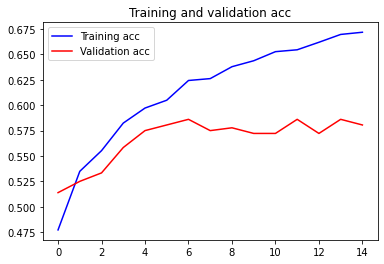

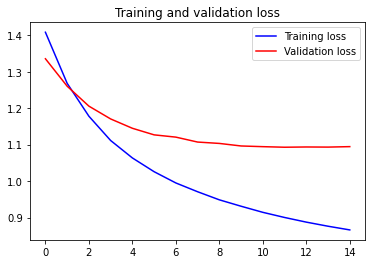

13/13 [==============================] - 0s 6ms/step - loss: 1.0407 - acc: 0.5975
loss:1.04
acc:0.60


In [20]:
### BEGIN SOLUTION

def runModel(model, model_name, X_train, X_test, y_train, y_test):
  plot_file = plotModel(model_simple, model_name)
  IPython.display.Image(plot_file) 

  model.summary()

  history = trainModelCat( model, X_train, y_train )

  plot_training(history)

  eval_model(model, X_test, y_test)


model_simple = Sequential( [ GlobalMaxPooling1D(input_shape=X_train_OHE.shape[-2:]),
                             Dense( len( np.unique(y_train) ), activation="softmax")
                           ]
                         )

runModel(model_simple, "OHE + GlobalMaxPooling", X_train_OHE, X_test_OHE, y_train, y_test)

### END SOLUTION

## Model: OHE + LSTM

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 4)                 6480      
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 25        
Total params: 6,505
Trainable params: 6,505
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
102/102 [==============================] - 3s 28ms/step - loss: 1.5316 - acc: 0.4914 - val_loss: 1.4510 - val_acc: 0.5056
Epoch 2/30
102/102 [==============================] - 2s 22ms/step - loss: 1.3797 - acc: 0.5281 - val_loss: 1.3549 - val_acc: 0.5056
Epoch 3/30
102/102 [==============================] - 2s 21ms/step - loss: 1.3382 - acc: 0.5281 - val_loss: 1.3398 -

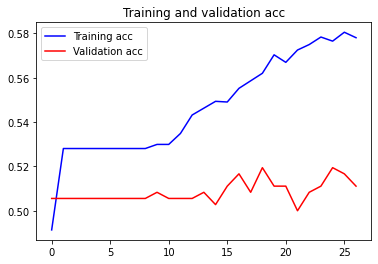

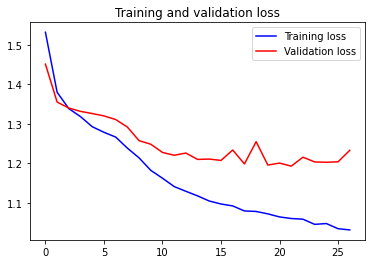

13/13 [==============================] - 0s 9ms/step - loss: 1.0917 - acc: 0.5700
loss:1.09
acc:0.57


In [21]:
### BEGIN SOLUTION
lstm_size_sm = 4
model_lstm = Sequential( [
                          LSTM(lstm_size_sm, input_shape=X_train_OHE.shape[-2:], recurrent_dropout=0.),
                          Dropout(0.3),
                          Dense( len( np.unique(y_train) ), activation="softmax")
                         ]
                       )

runModel(model_lstm, "OHE + LSTM", X_train_OHE, X_test_OHE, y_train, y_test)
### END SOLUTION

## Model: Embedding + GlobalMaxPooling 


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 16)           6416      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 85        
Total params: 6,501
Trainable params: 6,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
102/102 [==============================] - 1s 7ms/step - loss: 1.5132 - acc: 0.5133 - val_loss: 1.4458 - val_acc: 0.5056
Epoch 2/30
102/102 [==============================] - 1s 5ms/step - loss: 1.3677 - acc: 0.5281 - val_loss: 1.3524 - val_acc: 0.5056
Epoch 3/30
102/102 [==============================] - 1s 5ms/step - loss: 1.2966 - acc: 0.5281 - val_loss: 1.3247 - va

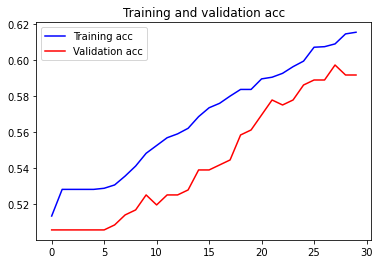

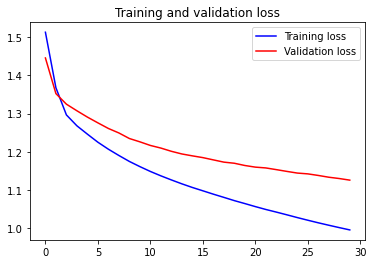

13/13 [==============================] - 0s 3ms/step - loss: 1.0770 - acc: 0.5700
loss:1.08
acc:0.57


In [22]:
### BEGIN SOLUTION
embed_size_sm=16
model_simple_es = Sequential( [Embedding(tok.num_words+1, embed_size_sm, input_length=words_in_doc_sm),
                             GlobalMaxPooling1D(),
                             Dense( len( np.unique(y_train) ), activation="softmax")
                         ]
                       )

runModel(model_simple_es, "Embedding + GlobalMaxPooling", X_train, X_test, y_train, y_test)
### END SOLUTION


# Embedding + LSTM (rather than GlobalPooling)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 16)           6416      
_________________________________________________________________
lstm_1 (LSTM)                (None, 4)                 336       
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 25        
Total params: 6,777
Trainable params: 6,777
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
102/102 [==============================] - 2s 23ms/step - loss: 1.4586 - acc: 0.5201 - val_loss: 1.3661 - val_acc: 0.5056
Epoch 2/30
102/102 [==============================] - 2s 18ms/step - loss: 1.3097 - acc: 0.5281 - val_loss: 1.3394 - val_acc: 0.5056
Epoch 3/30
102/102 [==============================] - 2s 18ms/step - loss: 1.2827 - acc: 0.5281 - val_loss: 1.3167 -

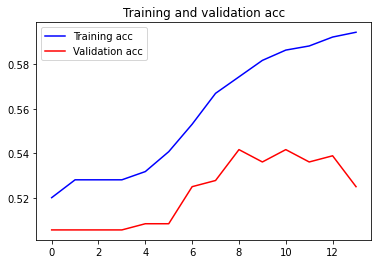

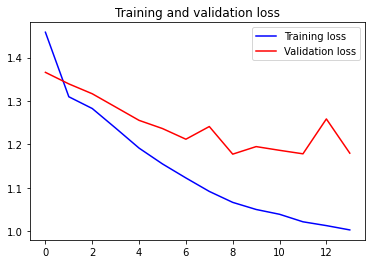

13/13 [==============================] - 0s 7ms/step - loss: 1.0729 - acc: 0.5925
loss:1.07
acc:0.59


In [23]:
### BEGIN SOLUTION
model_lstm_e = Sequential( [Embedding(tok.num_words+1, embed_size_sm, input_length=words_in_doc_sm),
                            LSTM(lstm_size_sm),
                          Dense( len( np.unique(y_train) ), activation="softmax")
                         ]
                       )

runModel(model_lstm_e, "Embedding + LSTM", X_train, X_test, y_train, y_test)
### END SOLUTION


# Try a larger vocab, since Embeddings are more compact


## model: Embedding Big + GlobalMaxPooling1D

((3600, 100), (3600,))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           64016     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 85        
Total params: 64,101
Trainable params: 64,101
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
102/102 [==============================] - 1s 7ms/step - loss: 1.5600 - acc: 0.4117 - val_loss: 1.5015 - val_acc: 0.5056
Epoch 2/30
102/102 [==============================] - 1s 6ms/step - loss: 1.4274 - acc: 0.5281 - val_loss: 1.3944 - val_acc: 0.5056
Epoch 3/30
102/102 [==============================] - 1s 6ms/step - loss: 1.3297 - acc: 0.5281 - val_loss: 1.3392 - 

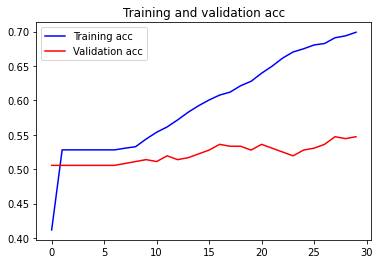

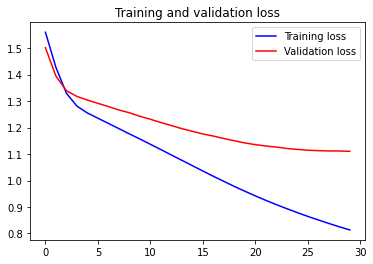

13/13 [==============================] - 0s 3ms/step - loss: 1.0598 - acc: 0.5650
loss:1.06
acc:0.56


In [24]:
### BEGIN SOLUTION
vocab_size_b, words_in_doc_b, embed_size_b, lstm_size_b = int(10*vocab_size_sm), words_in_doc_sm, int(1*embed_size_sm), lstm_size_sm
tok_b, encoded_docs_b, encoded_docs_padded_b = encodeDocs(docs, vocab_size=vocab_size_b, words_in_doc=words_in_doc_b)

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(encoded_docs_padded_b, sents, test_size=0.10, random_state=42)

X_train_b.shape, y_train_b.shape


model_simple_es_b = Sequential( [Embedding(tok_b.num_words+1, embed_size_b, input_length=words_in_doc_b),
                             GlobalMaxPooling1D(),
                          Dense( len( np.unique(y_train_b) ), activation="softmax")
                         ]
                       )

runModel(model_simple_es_b, "Embedding Big + GlobalMaxPooling", X_train_b, X_test_b, y_train_b, y_test_b)

### END SOLUTION

## Model: Embedding Big + LSTM

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 16)           64016     
_________________________________________________________________
lstm_2 (LSTM)                (None, 4)                 336       
_________________________________________________________________
dropout_1 (Dropout)          (None, 4)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 25        
Total params: 64,377
Trainable params: 64,377
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
102/102 [==============================] - 2s 24ms/step - loss: 1.3819 - acc: 0.5247 - val_loss: 1.3232 - val_acc: 0.5056
Epoch 2/30
102/102 [==============================] - 2s 19ms/step - loss: 1.2418 - acc: 0.5287 - val_loss: 1.2597 

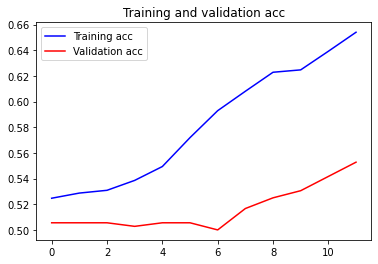

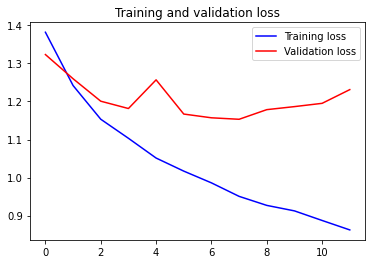

13/13 [==============================] - 0s 8ms/step - loss: 1.0544 - acc: 0.5950
loss:1.05
acc:0.60


In [25]:
### BEGIN SOLUTION
model_lstm_b = Sequential( [Embedding(tok_b.num_words+1, embed_size_b, input_length=words_in_doc_b),
                            LSTM(lstm_size_b),
                            Dropout(0.25),
                          Dense( len( np.unique(y_train_b) ), activation="softmax")
                         ]
                       )

runModel(model_lstm_b, "Embedding Big + LSTM", X_train_b, X_test_b, y_train_b, y_test_b)
### END SOLUTION

## Model: more complex




Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 16)           64016     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 16)           0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               1700      
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 505       
Total params: 66,221
Trainable params: 66,221
Non-trainable params: 0
__________________________________________________

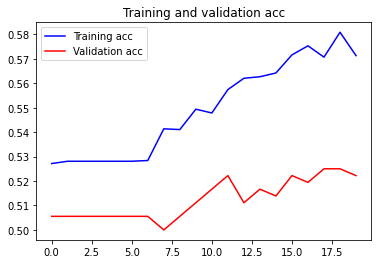

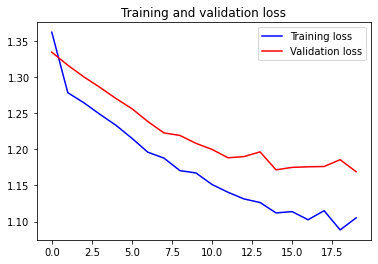

13/13 [==============================] - 0s 3ms/step - loss: 1.0928 - acc: 0.5850
loss:1.09
acc:0.58


In [26]:
### BEGIN SOLUTION 
model_x = Sequential( [Embedding(tok_b.num_words+1, embed_size_b, input_length=words_in_doc_b),
                          Dropout(0.25),
                          #LSTM(lstm_size_b), Dense(50, activation="relu"),
                          GlobalMaxPooling1D(),
                          Dropout(0.25),
                           Dense(100, activation="relu"),
                         
                          Dense( len( np.unique(y_train_b) ), activation="softmax")
                         ]
                       )

runModel(model_x, "Embedding Big + Compldex", X_train_b, X_test_b, y_train_b, y_test_b)
### END SOLUTION

# Submit your model


- Was the increase in number of weights compensated by a gain in accuracy when using a Recurrent Layer type compared to the Classifier only model ?
- Can you speculate why this is so ?

In [27]:
### BEGIN SOLUTION
model = model_simple

# This model uses non-standard features
X_test = X_test_OHE
### END SOLUTION

# Evaluate your model on the previously constructed test examples (out of sample)

In [28]:
loss_test, acc_test = eval_model(model, X_test, y_test)
# - loss_test: Loss, out of sample
# - acc_test:  Accuracy, out of sample.  This is what you will be graded on

13/13 [==============================] - 0s 4ms/step - loss: 1.0407 - acc: 0.5975
loss:1.04
acc:0.60


## How many weights in your Classifier only model ?

How many weights in your model ?

You should always be sensitive to how "big" your model is.

In [29]:
# Set variable
# - num_weight: number of weights in your model

### BEGIN SOLUTION
num_weights = model.count_params()
### END SOLUTION

# Discussion topics
- Compare the number of weights in each model.  Did the added complexity (more weights) lead to better performance ?
- **Where** were the largest increase in weights between models
  - Embeddings consume a lot of weights
    - But eliminates a dimension: single integer representation of a word vs a OHE vector of length words_in_vocab
    - So subsequent layers may need fewer weights compared to OHE
- Should we have formulated this as a Regression task rather than a Classification task ?
  - Is the difference in rating between 0 and 1 the same as between 3 and 4 ?
    - Perhaps there are bigger *absolute* differences in satisfaction  in lower ratings
      - i.e., Big difference between 0 and 1, smaller difference between 3 and 4